In [1]:
import os
import json
from typing import Dict, List, Optional, Union, cast
import requests
import pandas as pd
#import bamboolib as bam

import unicodedata
import re
import json

import acquire

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.cluster import KMeans

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import f_regression 

#statistical tests
from scipy import stats
from scipy.stats import pearsonr, spearmanr

from math import sqrt
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures


import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filter="ignore"

from bs4 import BeautifulSoup
import prepare
import plotly.express as px

#imports to show interactive visuals on github
import plotly.io as pio
pio.renderers

#forces dataframe to show every columns
pd.set_option('display.max_columns', None)

***

# `Acquire` Data.

In [2]:
df = acquire.get_fifa_data()

/var/folders/dc/8rtfvpyj2mb6mqbnfkf5dl400000gn/T/ipykernel_26075/1900469672.py:1: DtypeWarning:

Columns (81,85,104) have mixed types.Specify dtype option on import or set low_memory=False.



***

# Import [Prepare.py](https://github.com/Jules-Ray-Kayla-Bert-Capstone-FiFA/fifa/blob/main/prepare.py) File.
`Summary:`
    This file was created with the purpose of cleaning, encoding, scaling, dropping, and adding collumns to our existing data. It is necessary to complete this preperation step before we start exploring and modeling our data.

In [3]:
#defining df as our imported prepped data.
df = prepare.prepped_data(df) 

Before dropping nulls, 142079 rows, 111 cols
After dropping nulls. 131489 rows. 66 cols
After cleaning the data and adding additional columns there are: 98804 rows. 83 cols


In [4]:
cols = ['wage_eur','overall', 'passing', 'ball_control', 'short_passing', 'reactions', 'potential',
'dribbling']
def handle_outliers(df, cols, k):
    """this will eliminate most outliers, use a 1.5 k value if unsure because it is the most common, make sure to define cols value as the features
    you want the outliers to be handled. this should be done before running the function and outiside of it"""

    
    # Create placeholder dictionary for each columns bounds
    bounds_dict = {}
   
    for col in cols:
        # get necessary iqr values
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        upper_bound =  q3 + k * iqr
        lower_bound =  q1 - k * iqr

        #store values in a dictionary referencable by the column name
        #and specific bound
        bounds_dict[col] = {}
        bounds_dict[col]['upper_bound'] = upper_bound
        bounds_dict[col]['lower_bound'] = lower_bound

    for col in cols:
        #retrieve bounds
        col_upper_bound = bounds_dict[col]['upper_bound']
        col_lower_bound = bounds_dict[col]['lower_bound']

        #remove rows with an outlier in that column
        df = df[(df[col] < col_upper_bound) & (df[col] > col_lower_bound)]
        
    return df

handle_outliers(df,cols,1.5)

,sofifa_id,short_name,player_positions,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,club_name,league_name,nationality_id,nationality_name,club_position,position,field_position,club_joined,club_contract_valid_until,body_type,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,pace,shooting,passing,dribbling,defending,physical,crossing,finishing,heading_accuracy,short_passing,volleys,skill_dribbling,curve,fk_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,gk_speed,year,total_wage,age_bins,height_bins,weight_bins,year_joined,wage_year,league_yr_sum,club_name_yr_sum,seniority,club_position_encoded,work_rate_encoded,preferred_foot_encoded,age_bins_encoded,weight_bins_encoded,body_type_encoded,league_encoded
26,245367,X. Simons,CM,66,83,2200000.0,6000.0,18,168,58,73.0,Paris Saint-Germain,French Ligue 1,34,Netherlands,RES,Reserves,Reserves,2019-07-23,2022.0,Normal (170-),Right,3,3,1,Medium/High,68,57,66,70,57,60,60,57,39,69,49,70,71,61,65,69,70,66,73,63,84,59,56,61,55,55,72,61,67,68,58,56,64,52,9,11,5,8,10,0,2022,2206000.0,younger,short,slim,2019,312000.0,5.034099e+09,991694600.0,3,22,6,2,2,1,6,4
27,261249,É. Michut,CM,65,82,1800000.0,6000.0,18,178,68,73.0,Paris Saint-Germain,French Ligue 1,18,France,RES,Reserves,Reserves,2020-07-01,2025.0,Lean (170-185),Right,3,3,1,High/Medium,65,53,64,71,56,49,55,50,45,70,48,70,61,48,66,70,68,62,75,62,80,58,45,50,45,55,60,61,58,67,55,55,60,51,9,13,11,8,9,0,2022,1806000.0,younger,medium,slim,2020,312000.0,5.034099e+09,991694600.0,2,22,8,2,2,1,3,4
28,250822,B. Fadiga,"CM, CAM",64,78,1400000.0,11000.0,20,178,70,73.0,Paris Saint-Germain,French Ligue 1,18,France,RES,Reserves,Reserves,2020-07-01,2022.0,Lean (170-185),Right,3,3,1,High/Medium,75,47,60,71,59,53,48,46,55,67,37,71,52,47,61,69,77,73,86,65,77,52,55,68,40,43,65,61,58,62,50,55,63,56,12,14,14,15,15,0,2022,1411000.0,younger,medium,average,2020,572000.0,5.034099e+09,991694600.0,2,22,8,2,2,2,3,4
29,263194,I. Gharbi,"LW, CAM",63,80,1200000.0,3000.0,17,167,58,73.0,Paris Saint-Germain,French Ligue 1,18,France,RES,Reserves,Reserves,2021-07-01,2022.0,Lean (170-),Right,3,3,1,Medium/Medium,71,55,60,71,40,40,55,54,35,62,49,71,68,52,57,67,75,68,81,55,88,60,49,41,34,54,51,40,57,64,60,37,45,38,7,9,13,15,8,0,2022,1203000.0,younger,short,slim,2021,156000.0,5.034099e+09,991694600.0,1,22,5,2,2,1,8,4
30,264026,N. Bitumazala,"RB, CDM",61,77,800000.0,3000.0,18,178,68,73.0,Paris Saint-Germain,French Ligue 1,18,France,RES,Reserves,Reserves,2020-09-03,2023.0,Lean (170-185),Right,3,3,1,Medium/Medium,67,42,55,63,59,56,47,39,53,64,38,62,52,41,60,65,68,67,64,54,71,53,57,49,55,36,68,60,41,49,45,57,63,59,7,14,14,11,11,0,2022,803000.0,younger,medium,slim,2020,156000.0,5.034099e+09,991694600.0,2,22,5,2,2,1,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98799,234292,L. Järvenpää,RB,57,70,180000.0,500.0,19,182,76,100325.0,HJK Helsinki,Finnish Veikkausliiga,17,Finland,SUB,Substitute,Subs,2016-01-01,2020.0,Normal (170-185),Right,3,2,1,Medium/Medium,70,26,41,43,55,66,56,25,52,41,23,41,37,31,30,35,67,72,59,50,63,27,60,79,63,23,57,56,42,38,35,57,53,52,14,15,6,8,9,0,2017,180500.0,younger,medium,average,2016,26000.0,3.504800e+06,3504800.0,1,12,5,2,2,2,2,42
98800,234294,L. Lingman,RW,57,72,230000.0,500.0,18,174,65,100325.0,HJK Helsinki,Finnish Veikkausliiga,17,Finland,SUB,Substitute,Subs,2016-01-01,2020.0,Lean (170-185),Right,3,2,1,Medium/Medium,70,46,50,63,29,56,61,45,39,51,45,61,34,41,45,59,68,72,81,56,82,52,67,82,52

# Seperating Goalkeepers, Forwards, & Midfielders

In [5]:
goalkeeper_df, forward_df, midfielder_df, defender_df = prepare.acquire_players_by_position(df)

/Users/albertcontreras/codeup-data-science/fifa/Contreras/prepare.py:428: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/albertcontreras/codeup-data-science/fifa/Contreras/prepare.py:437: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Focusing on midfielders on this section

In [6]:
df = midfielder_df
df

,sofifa_id,short_name,player_positions,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,club_name,league_name,nationality_id,nationality_name,club_position,position,field_position,club_joined,club_contract_valid_until,body_type,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,pace,shooting,passing,dribbling,defending,physical,crossing,finishing,heading_accuracy,short_passing,volleys,skill_dribbling,curve,fk_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,gk_speed,year,total_wage,age_bins,height_bins,weight_bins,year_joined,wage_year,league_yr_sum,club_name_yr_sum,seniority,club_position_encoded,work_rate_encoded,preferred_foot_encoded,age_bins_encoded,weight_bins_encoded,body_type_encoded,league_encoded
7,199556,M. Verratti,"CM, CAM",87,87,79500000.0,155000.0,28,165,60,73.0,Paris Saint-Germain,French Ligue 1,27,Italy,LCM,Left Centre Midfield,Midfielder,2012-07-18,2024.0,Unique,Right,4,4,3,Medium/High,64,61,87,91,79,67,82,60,57,90,64,91,85,64,89,92,68,60,91,87,94,60,67,76,54,58,89,85,78,89,64,78,82,84,12,12,15,15,10,0,2022,79655000.0,younger,short,slim,2012,8060000.0,5.034099e+09,991694600.0,10,11,6,2,2,1,1,4
10,181291,G. Wijnaldum,"CM, CDM",84,84,40500000.0,115000.0,30,175,74,73.0,Paris Saint-Germain,French Ligue 1,34,Netherlands,RCM,Right Centre Midfield,Midfielder,2021-07-01,2024.0,Unique,Right,4,4,3,High/High,77,75,80,86,79,79,72,75,78,87,73,85,78,73,81,88,78,76,84,86,88,78,81,93,74,73,75,80,79,79,74,79,80,70,16,6,14,12,6,0,2022,40615000.0,older,medium,average,2021,5980000.0,5.034099e+09,991694600.0,1,4,9,2,1,2,1,4
35,199556,M. Verratti,"CM, CDM",86,87,77500000.0,135000.0,27,165,60,73.0,Paris Saint-Germain,French Ligue 1,27,Italy,LCM,Left Centre Midfield,Midfielder,2012-07-18,2024.0,Unique,Right,4,4,3,Medium/High,64,60,85,90,79,67,75,60,55,90,64,90,78,64,89,90,68,61,91,87,94,56,65,76,53,58,89,85,71,88,64,78,82,83,12,12,15,15,10,0,2021,77635000.0,younger,short,slim,2012,7020000.0,5.034099e+09,991694600.0,9,11,6,2,2,1,1,4
38,193474,I. Gueye,"CDM, CM",84,84,35500000.0,105000.0,30,174,66,73.0,Paris Saint-Germain,French Ligue 1,136,Senegal,RCM,Right Centre Midfield,Midfielder,2019-07-30,2023.0,Lean (170-185),Right,3,3,2,Medium/High,69,61,71,78,85,79,60,53,69,81,32,76,49,61,77,79,70,69,81,83,81,80,89,91,69,66,86,89,69,68,54,84,90,83,8,6,8,12,13,0,2021,35605000.0,older,medium,slim,2019,5460000.0,5.034099e+09,991694600.0,2,4,6,2,1,1,3,4
60,190871,Neymar Jr,"LW, CAM",92,92,105500000.0,290000.0,27,175,68,73.0,Paris Saint-Germain,French Ligue 1,54,Brazil,CAM,Centre Attacking Midfield,Midfielder,2017-08-03,2022.0,Unique,Right,5,5,5,High/Medium,91,85,87,95,32,58,87,87,62,87,87,96,88,87,81,95,94,89,96,92,84,80,61,81,49,84,51,36,87,90,90,27,26,29,9,9,15,15,11,0,2020,105790000.0,younger,medium,slim,2017,15080000.0,5.034099e+09,991694600.0,3,13,8,2,2,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98649,233111,P. Brennan,CM,48,59,50000.0,500.0,19,177,75,111968.0,Wexford Youths,Rep. Ireland Airtricity League,25,Republic of Ireland,RES,Reserves,Reserves,2016-02-01,2020.0,Normal (170-185),Right,3,2,1,Medium/Medium,65,35,45,48,40,56,33,28,50,55,36,45,35,32,52,47,68,62,56,53,57,51,55,58,55,32,58,41,45,41,34,37,38,45,9,12,12,12,11,0,2017,50500.0,younger,medium,average,2016,26000.0,1.222338e+08,650000.0,1,22,5,2,2,2,2,24
98651,236309,C. Sutton,CM,47,69,70000.0,500.0,18,180,75,111968.0,Wexford Youths,Rep. Ireland Airtricity League,25,Republic of Ireland,RES,Reserves,Reserves,201

In [7]:
train, validate, test = prepare.split(df)

Train: 21872 rows, 83 cols
Validate: 9695 rows, 83 cols
Test: 5115 rows, 83 cols


# `Explore`

## Importing split function to start our exploring on our train data.

***
# Relationship to Wage_euro Plot

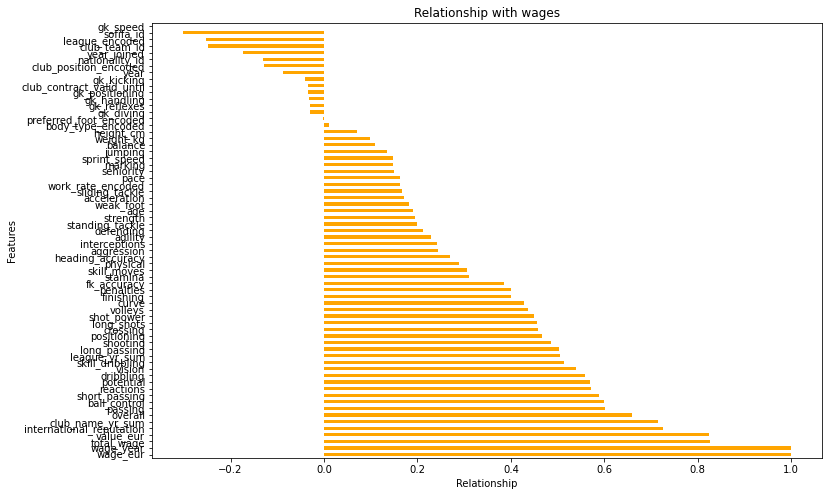

In [8]:
plt.figure(figsize = (12,8))
train.corr()['wage_eur'].sort_values(ascending=False).plot(kind='barh', color='orange')
plt.title('Relationship with wages')
plt.xlabel('Relationship')
plt.ylabel('Features')
plt.show()

In [9]:
features_cor =  train.corr()['wage_eur'].sort_values(ascending=False)
features_cor = pd.DataFrame(features_cor)
features_cor.tail(64)

,wage_eur
total_wage,0.825335
value_eur,0.823790
international_reputation,0.724793
club_name_yr_sum,0.714032
overall,0.659235
...,...
year_joined,-0.173610
club_team_id,-0.248620
league_encoded,-0.252098
sofifa_id,-0.302797


In [10]:
# from sklearn.feature_selection import RFE
# # initialize the ML algorithm
# lm = LinearRegression()
# # create the rfe object, indicating the ML object (lm) and the number of features I want to end up with.
# rfe = RFE(lm, n_features_to_select=15)
# # fit the data using RFE
# rfe.fit(X , y)
# # get the mask of the columns selected
# feature_mask = rfe.support_
# # get list of the column names.
# rfe_feature = X.iloc[:,feature_mask].columns.tolist()

`Takeaways:` 
For this Exploration section I wil be focusing on the skills that are under or equal to 70 percent of correlation and greater then 48 percent. 
The list below will be the skills and stats that I will be focusing on.

- overall
- passing
- ball_control
- short_passing
- reactions
- potential
- dribbling
- vision
- skill_dribbling
- league_yr_sum
- long_passing
- shooting



In [11]:
# identifying mvp columns for midfielders
mvp = ['international_reputation','overall', 'passing', 'ball_control', 'short_passing', 'reactions', 'potential',
'dribbling', 'vision'] #'skill_dribbling', 'league_yr_sum', 'long_passing', 'shooting'

In [12]:
X_train = train[mvp]
y_train = train['wage_eur']

X_validate = validate[mvp]
y_validate = validate['wage_eur']

X_test = test[mvp]
y_test = test['wage_eur']

# Scaling

In [13]:
scaler = RobustScaler()
# Note that we only call .fit with the training data,
# but we use .transform to apply the scaling to all the data splits.
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)


In [14]:
#scaler, X_train_scaled, X_validate_scaled, X_test_scaled = scale_data(X_train, X_validate, X_test, return_scaler=True)

# RMSE

In [15]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values.
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
# 1. Predict price_pred_mean
wage_eur_pred_mean = y_train.wage_eur.mean()
# creating a wage_eur_pred_mean column for my y_train
y_train['wage_eur_pred_mean'] = y_train.wage_eur.mean()
# creating a wage_eur_pred_mean column for my y_validate
y_validate['wage_eur_pred_mean'] = y_validate.wage_eur.mean()
# 2. compute price_pred_median
# creating a predictive median for y train 
y_train['wage_eur_pred_median'] = y_train.wage_eur.median()
# creating a predictive median for y_validate
y_validate['wage_eur_pred_median'] = y_validate.wage_eur.median()
# 3. RMSE of price_pred_mean
rmse_train = mean_squared_error(y_train.wage_eur, y_train.wage_eur_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.wage_eur, y_validate.wage_eur_pred_mean)**(1/2)
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2),
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))
# 4. RMSE of wage_eur_pred_median
rmse_train = mean_squared_error(y_train.wage_eur, y_train.wage_eur_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.wage_eur, y_validate.wage_eur_pred_median)**(1/2)
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2),
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  26510.85 
Validate/Out-of-Sample:  23544.79
RMSE using Median
Train/In-Sample:  28428.28 
Validate/Out-of-Sample:  24664.47


In [16]:
y_test = pd.DataFrame(y_test)

y_test

,wage_eur
7,155000.0
10,115000.0
237,41000.0
239,50000.0
240,43000.0
...,...
97782,500.0
97786,500.0
97788,500.0
98071,500.0


In [17]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train_scaled, y_train.wage_eur)

# predict train
y_train['wage_eur_pred_lm'] = lm.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.wage_eur, y_train.wage_eur_pred_lm)**(1/2)

# predict validate
y_validate['wage_eur_pred_lm'] = lm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate_lm = mean_squared_error(y_validate.wage_eur, y_validate.wage_eur_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate_lm)

RMSE for OLS using LinearRegression
Training/In-Sample:  15983.346217445684 
Validation/Out-of-Sample:  16155.832648084172


In [18]:
#residuals
y_train['lm_residuals'] = y_train['wage_eur_pred_lm'] - y_train['wage_eur']
y_validate['lm_residuals'] = y_validate['wage_eur_pred_lm'] - y_validate['wage_eur']

# LassoLars(lars)

In [19]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train_scaled, y_train.wage_eur)

# predict train
y_train['wage_eur_pred_lars'] = lars.predict(X_train_scaled)

# evaluate: rmse
rmse_train_lars = mean_squared_error(y_train.wage_eur, y_train.wage_eur_pred_lars)**(1/2)

# predict validate
y_validate['wage_eur_pred_lars'] = lars.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate_lars = mean_squared_error(y_validate.wage_eur, y_validate.wage_eur_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train_lars, 
      "\nValidation/Out-of-Sample: ", rmse_validate_lars)

RMSE for Lasso + Lars
Training/In-Sample:  15992.596675422354 
Validation/Out-of-Sample:  16138.839735271371


In [20]:
#residuals
y_train['lars_residuals'] = y_train['wage_eur_pred_lars'] - y_train['wage_eur']
y_validate['lars_residuals'] = y_validate['wage_eur_pred_lars'] - y_validate['wage_eur']

# Twedie Regression Model (GLM)

In [21]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train_scaled, y_train.wage_eur)

# predict train
y_train['wage_eur_pred_glm'] = glm.predict(X_train_scaled)

# evaluate: rmse
rmse_train_glm = mean_squared_error(y_train.wage_eur, y_train.wage_eur_pred_glm)**(1/2)

# predict validate
y_validate['wage_eur_pred_glm'] = glm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate_glm = mean_squared_error(y_validate.wage_eur, y_validate.wage_eur_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate_glm)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  15983.346217445684 
Validation/Out-of-Sample:  11964.921197944845


In [22]:
#residuals
y_train['glm_residuals'] = y_train['wage_eur_pred_glm'] - y_train['wage_eur']
y_validate['glm_residuals'] = y_validate['wage_eur_pred_glm'] - y_validate['wage_eur']

# Polynomial Regression

In [23]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 = pf.transform(X_test_scaled)

In [24]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.wage_eur)

# predict train
y_train['wage_eur_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train_lm2 = mean_squared_error(y_train.wage_eur, y_train.wage_eur_pred_lm2)**(1/2)

# predict validate
y_validate['wage_eur_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate_lm2 = mean_squared_error(y_validate.wage_eur, y_validate.wage_eur_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  15983.346217445684 
Validation/Out-of-Sample:  24664.472082006214


In [25]:
#residuals
y_train['poly_residuals'] = y_train['wage_eur_pred_lm2'] - y_train['wage_eur']
y_validate['poly_residuals'] = y_validate['wage_eur_pred_lm2'] - y_validate['wage_eur']

# Evaluating Models

In [26]:
from sklearn.linear_model import LinearRegression
y = pd.DataFrame(y_train.wage_eur)
X = pd.DataFrame(X_train_scaled)
# assuming X and y are already defined
model = LinearRegression().fit(X, y)
train['yhat'] = model.predict(X)

In [27]:
df = pd.DataFrame(train[['overall', 'passing', 'ball_control', 'short_passing', 'reactions', 'potential',
'dribbling','wage_eur','yhat']])
df.head()

,overall,passing,ball_control,short_passing,reactions,potential,dribbling,wage_eur,yhat
215,83,76,77,83,83,85,76,150000.0,95083.580658
216,82,78,83,84,78,82,73,130000.0,91362.565299
221,80,80,85,86,82,86,84,90000.0,64280.930130
449,83,77,79,83,82,83,71,90000.0,92990.889564
450,83,83,84,86,82,83,82,110000.0,94211.174972


In [28]:
#creating a baseline from the mean of the target variable
baseline = y.mean()
df['baseline'] = y.wage_eur.mean()
# turning baseline to int from float
df.baseline = df.baseline.astype(int)
# residual = actual - predicted
df['residual'] = df.wage_eur - df.yhat
df['baseline_residual'] = df.wage_eur - df.baseline

In [29]:
baseline

wage_eur    15263.624726
dtype: float64

In [30]:
df['residual^2'] = df.residual**2
df['baseline_residual^2'] = df.baseline_residual**2

df.head()

,overall,passing,ball_control,short_passing,reactions,potential,dribbling,wage_eur,yhat,baseline,residual,baseline_residual,residual^2,baseline_residual^2
215,83,76,77,83,83,85,76,150000.0,95083.580658,15263,54916.419342,134737.0,3.015813e+09,1.815406e+10
216,82,78,83,84,78,82,73,130000.0,91362.565299,15263,38637.434701,114737.0,1.492851e+09,1.316458e+10
221,80,80,85,86,82,86,84,90000.0,64280.930130,15263,25719.069870,74737.0,6.614706e+08,5.585619e+09
449,83,77,79,83,82,83,71,90000.0,92990.889564,15263,-2990.889564,74737.0,8.945420e+06,5.585619e+09
450,83,83,84,86,82,83,82,110000.0,94211.174972,15263,15788.825028,94737.0,2.492870e+08,8.975099e+09


In [31]:
SSE = df['residual^2'].sum()
SSE_baseline = df['baseline_residual^2'].sum()

print('SSE =', "{:.1f}".format(SSE))
print("SSE Baseline =", "{:.1f}".format(SSE_baseline))

if SSE < SSE_baseline:
    print('SSE is better than baseline')
else:
    print('baseline is better')

SSE = 5587582017140.9
SSE Baseline = 15372188448368.0
SSE is better than baseline


In [32]:
MSE = SSE/len(df)
MSE_baseline = SSE_baseline/len(df)

print("MSE = ", "{:.1f}".format(MSE))
print("MSE baseline = ", "{:.1f}".format(MSE_baseline))

if MSE < MSE_baseline:
    print('MSE is better than baseline')
else:
    print('baseline is better')

MSE =  255467356.3
MSE baseline =  702825002.2
MSE is better than baseline


In [33]:
from math import sqrt
RMSE = sqrt(MSE)
RMSE_baseline =  sqrt(MSE_baseline)

if RMSE < RMSE_baseline:
    print('RMSE is better than baseline')
else:
    print('baseline is better')
    
print("RMSE = ", "{:.1f}".format(RMSE))
print("RMSE baseline = ", "{:.1f}".format(RMSE_baseline))

RMSE is better than baseline
RMSE =  15983.3
RMSE baseline =  26510.8


In [34]:
if SSE < SSE_baseline:
    print('OLS regression model performs better than the baseline')
else:
    print('OLS regression model performs worse than the baseline')

OLS regression model performs better than the baseline


In [35]:
# sklearn.metrics.explained_variance_score
from sklearn.metrics import explained_variance_score
evs = explained_variance_score(df.wage_eur, df.yhat)
print('Explained Variance = ', round(evs,3))

Explained Variance =  0.637


In [36]:
# calculate R2 the easy way:
from sklearn.metrics import r2_score
r2_score(df.wage_eur, df.yhat)

0.6365135622028537

In [37]:
import statsmodels.api as sm
X2 = sm.add_constant(df.potential)
est = sm.OLS(df.wage_eur, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:               wage_eur   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                 1.044e+04
Date:                Tue, 09 Aug 2022   Prob (F-statistic):               0.00
Time:                        16:54:42   Log-Likelihood:            -2.4954e+05
No. Observations:               21872   AIC:                         4.991e+05
Df Residuals:                   21870   BIC:                         4.991e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.448e+05   1573.429    -92.039      0.0

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



In [38]:
def residuals(actual, predicted):
    return actual - predicted

#sum of squared errors (SSE)
def sse(actual, predicted):
    return (residuals(actual, predicted) **2).sum()

#explained sum of squares (ESS)
def ess(actual, predicted):
    return ((predicted - actual.mean()) ** 2).sum()

#total sum of squares (TSS)
def tss(actual):
    return ((actual - actual.mean()) ** 2).sum()

#mean squared error (MSE)
def mse(actual, predicted):
    n = actual.shape[0]
    return sse(actual, predicted) / n

#root mean squared error (RMSE)
def rmse(actual, predicted):
    return math.sqrt(mse(actual, predicted))

# returns r2 scor
def r2_score(actual, predicted):
    return ess(actual, predicted) / tss(actual)

def regression_errors(actual, predicted):
    return pd.Series({
                        'SSE': sse(actual, predicted),
                        'ESS': ess(actual, predicted),
                        'TSS': tss(actual),
                        'MSE': mse(actual, predicted),
                        'RMSE': rmse(actual, predicted),
                        })

def baseline_mean_errors(actual):
    predicted = actual.mean()
    return {
             'SSE': sse(actual, predicted),
             'MSE': mse(actual, predicted),
             'RMSE': rmse(actual, predicted),
            }

def better_than_baseline(actual, predicted):
    rmse_baseline = rmse(actual, actual.mean())
    rmse_model = rmse(actual, predicted)
    return rmse_model < rmse_baseline

In [39]:
actual = y_train.wage_eur
predicted = df.yhat
residuals = actual - predicted

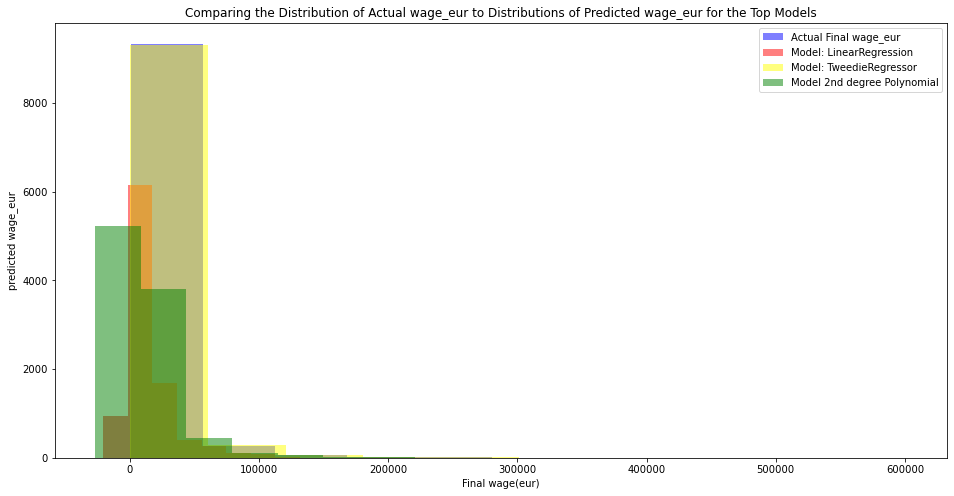

In [40]:
def actual_vs_predicted():
    # plot to visualize actual vs predicted. 
    plt.figure(figsize=(16,8))
    plt.hist(y_validate.wage_eur, color='blue', alpha=.5, label="Actual Final wage_eur")
    plt.hist(y_validate.wage_eur_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
    plt.hist(y_validate.wage_eur_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
    plt.hist(y_validate.wage_eur_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
    plt.xlabel("Final wage(eur)")
    plt.ylabel("predicted wage_eur")
    plt.title("Comparing the Distribution of Actual wage_eur to Distributions of Predicted wage_eur for the Top Models")
    plt.legend()
    plt.show()
actual_vs_predicted()

In [41]:
y_validate = pd.DataFrame(y_validate)

# predict on test
y_validate['wage_eur_pred_LINEAR'] = lm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate_lm = mean_squared_error(y_validate.wage_eur, y_validate.wage_eur_pred_LINEAR)**(1/2)

print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", rmse_validate_lm)

y_validate = pd.DataFrame(y_validate)

# predict on test
y_validate['wage_eur_pred_LASSO'] = lars.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate_lars = mean_squared_error(y_validate.wage_eur, y_validate.wage_eur_pred_LASSO)**(1/2)

print("RMSE for OLS Model using Lasso\nOut-of-Sample Performance: ", rmse_validate_lars)

y_vaidate = pd.DataFrame(y_validate)

#predict on test
y_validate['pred_Poly'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_test = mean_squared_error(y_validate.wage_eur, y_validate.pred_Poly)**(0.5)

print(f"""
RMSE for Polynomial Regressor, degrees=2:
Test/Out-of-Sample Performance: {rmse_validate}
""")



#predict on test
y_validate['wage_eur_pred_glm'] = glm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_test.wage_eur, y_validate.wage_eur_pred_glm)**(1/2)
print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate_glm)


RMSE for OLS Model using LinearRegression
Out-of-Sample Performance:  16155.832648084172
RMSE for OLS Model using Lasso
Out-of-Sample Performance:  16138.839735271371

RMSE for Polynomial Regressor, degrees=2:
Test/Out-of-Sample Performance: 24664.472082006214



ValueError: Found input variables with inconsistent numbers of samples: [5115, 9695]

In [42]:
y_train

,wage_eur,wage_eur_pred_mean,wage_eur_pred_median,wage_eur_pred_lm,lm_residuals,wage_eur_pred_lars,lars_residuals,wage_eur_pred_glm,glm_residuals,wage_eur_pred_lm2,poly_residuals
215,150000.0,15263.624726,5000.0,95083.580658,-54916.419342,93932.902992,-56067.097008,105082.969707,-44917.030293,120465.965687,-29534.034313
216,130000.0,15263.624726,5000.0,91362.565299,-38637.434701,91171.776275,-38828.223725,95670.769276,-34329.230724,103124.503626,-26875.496374
221,90000.0,15263.624726,5000.0,64280.930130,-25719.069870,63431.580728,-26568.419272,77142.393556,-12857.606444,75094.533049,-14905.466951
449,90000.0,15263.624726,5000.0,92990.889564,2990.889564,92463.554396,2463.554396,101113.507202,11113.507202,114143.279471,24143.279471
450,110000.0,15263.624726,5000.0,94211.174972,-15788.825028,93627.808514,-16372.191486,113520.377982,3520.377982,116960.551610,6960.551610
...,...,...,...,...,...,...,...,...,...,...,...
94345,1000.0,15263.624726,5000.0,1285.037704,285.037704,876.922030,-123.077970,2454.929819,1454.929819,850.929287,-149.070713
94347,1000.0,15263.624726,5000.0,-3859.243281,-4859.243281,-3558.857125,-4558.857125,1331.488791,331.488791,746.409711,-253.590289
96694,1000.0,15263.624726,5000.0,-3449.298124,-4449.298124,-3183.731555,-4183.731555,1964.401506,964.401506,543.714495,-456.285505
97753,500.0,15263.624726,5000.0,-169.866859,-669.866859,-102.081267,-602.081267,2046.046879,1546.046879,562.224712,62.224712


In [43]:
metric_df = pd.DataFrame(data=[{
    'model': 'mean_baseline', 
    'RMSE_validate': rmse_validate,
        'r^2_validate': explained_variance_score(y_validate.wage_eur, y_validate.wage_eur_pred_mean)}])
metric_df = metric_df.append({
    'model': 'OLS Regressor', 
    'RMSE_validate': rmse_validate_lm,
    'r^2_validate': explained_variance_score(y_validate.wage_eur, y_validate.wage_eur_pred_lm)}, ignore_index=True)
metric_df = metric_df.append({
    'model': 'Lasso alpha 1', 
    'RMSE_validate': rmse_validate_lars,
    'r^2_validate': explained_variance_score(y_validate.wage_eur, y_validate.wage_eur_pred_lars)}, ignore_index=True)
metric_df = metric_df.append({
    'model': 'GLM (TweedieRegressor)', 
    'RMSE_validate': rmse_validate_glm,
    'r^2_validate': explained_variance_score(y_validate.wage_eur, y_validate.wage_eur_pred_glm)}, ignore_index=True)
metric_df = metric_df.append({
    'model': 'Poly', 
    'RMSE_validate': rmse_validate_lm2,
    'r^2_validate': explained_variance_score(y_validate.wage_eur, y_validate.wage_eur_pred_lm2)}, ignore_index=True)

In [44]:
metric_df  

,model,RMSE_validate,r^2_validate
0,mean_baseline,24664.472082,0.000000
1,OLS Regressor,16155.832648,0.549887
2,Lasso alpha 1,16138.839735,0.550708
3,GLM (TweedieRegressor),11964.921198,0.769423
4,Poly,12495.731663,0.738862


In [ ]:
stop # Marketability percent_change_train = ((baseline - RMSE_train ) / baseline) * 100

In [ ]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['wage_eur_pred_LINEAR'] = lm.predict(X_test_scaled)

# evaluate: rmse
rmse_test_lm = mean_squared_error(y_test.wage_eur, y_test.wage_eur_pred_LINEAR)**(1/2)

print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test_lm)

y_test = pd.DataFrame(y_test)

# predict on test
y_test['wage_eur_pred_LASSO'] = lars.predict(X_test_scaled)

# evaluate: rmse
rmse_test_lars = mean_squared_error(y_test.wage_eur, y_test.wage_eur_pred_LASSO)**(1/2)

print("RMSE for OLS Model using Lasso\nOut-of-Sample Performance: ", rmse_test_lars)

y_test = pd.DataFrame(y_test)

#predict on test
y_test['pred_Poly'] = lm2.predict(X_test_degree2)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.wage_eur, y_test.pred_Poly)**(0.5)

print(f"""
RMSE for Polynomial Regressor, degrees=2:
Test/Out-of-Sample Performance: {rmse_test}
""")



#predict on test
y_test['wage_eur_pred_glm'] = glm.predict(X_test_scaled)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.wage_eur, y_test.wage_eur_pred_glm)**(1/2)
print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate_glm)


In [ ]:
y_test

In [ ]:
sns.scatterplot(data = y_test)


In [ ]:
features = ['overall', 'potential', 'age', 'height_cm', 'weight_kg', 'club_team_id', 'nationality_id',
        'weak_foot', 'skill_moves', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physical',
        'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys', 'skill_dribbling',
        'curve', 'fk_accuracy', 'long_passing', 'ball_control', 'acceleration', 'sprint_speed', 'agility',
        'reactions', 'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots', 'aggression',
        'interceptions', 'positioning', 'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
        'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes', 'gk_speed', 'year',
        'year_joined', 'seniority', 'work_rate_encoded', 'preferred_foot_encoded',
        'age_bins_encoded', 'weight_bins_encoded', 'body_type_encoded', 'league_encoded', 'bmi']
train_scaled, validate_scaled, test_scaled = model.scale_data(train, validate, test)
X = train_scaled[features]
y = train[['wage_eur']]
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
# initialize the ML algorithm
lm = LinearRegression()
# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with.
rfe = RFE(lm, n_features_to_select=10)
# fit the data using RFE
rfe.fit(X , y)
# get the mask of the columns selected
feature_mask = rfe.support_
# get list of the column names.
rfe_feature = X.iloc[:,feature_mask].columns.tolist()
rfe_feature